This notebook presents the parameterized parametrization of a Catmull Rom curve. Selecting an alpha value results in unique knot vector that affect the curve geometry, we make use of simple tools to plot the curvature metric along the expression, such as color maps. An alpha value of $1/2$ guarantees a curve with no self intersections, but our interests relies on rendering a simple animation to visualize the alpha parameter space in relation with the curvature metric computed on the resulting geometry.

$$
\begin{equation*}
t_{i+1} = t_i + |\boldsymbol{x}_{i+1} - \boldsymbol{x}_i|^\alpha
\end{equation*}
$$

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

import matplotlib.animation as animation 

In [3]:
from matplotlib.collections import LineCollection

from matplotlib.colors import LinearSegmentedColormap  

from IPython import display 

In [4]:
import sys

sys.path.append( '../../..')

In [5]:
from lib_spline.catmullrom import CatmullRom
from lib_spline.piecewise import Piecewise
from lib_spline.grid import alpha_param

In [6]:
from lib_param.interface.expression import Expression

### Alpha Values

In [7]:
points = np.array([
    
    (-1, -0.5),
    (0, 2.3),
    (0.15, 2.1),
    (4, 1.3),
    (3.8, -0.2),
    (2.5, 0.1),
    (3.15, 0.75),
])

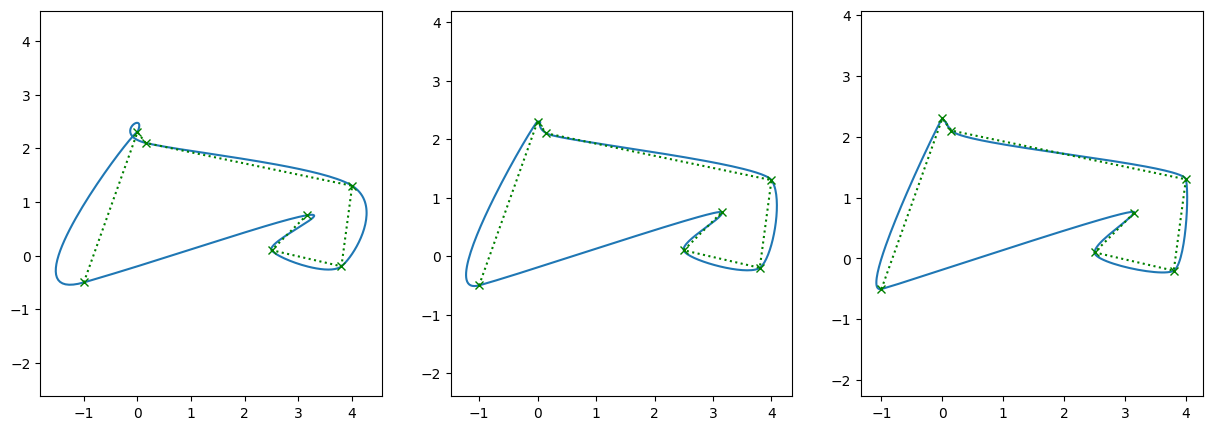

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

alphas = [0.01, 0.5, 1.0]

renders = []

for idx, alpha in enumerate(alphas):

    new_grid = alpha_param( alpha, points, closed = True)
    catmull = CatmullRom( points, new_grid, closed = True )
    tetha = np.linspace(catmull.grid[0], catmull.grid[-1], 300)
    render = np.array([catmull.evaluate(t) for t in tetha])

    renders.append(render)

    axs[idx].plot(*render.T)
    axs[idx].plot(*points.T, 'x:g')
    axs[idx].axis('equal');

plt.show()

### Perametrized Animation

In [9]:
# init data:

new_grid = alpha_param(alpha, points, closed = True)
catmull = CatmullRom( points, new_grid, closed = True )
tetha = np.linspace(catmull.grid[0], catmull.grid[-1], 300)
render = np.array([catmull.evaluate(t) for t in tetha])

points_1 = render.reshape(-1,1,2)
segments = np.concatenate([points_1[:-1],points_1[1:]], axis=1)

In [10]:
e = Expression (catmull)

curvature = np.array([e.curvature(t) for t in tetha])

In [11]:
cmap = LinearSegmentedColormap.from_list("", [(0, 0, 1), (1, 0, 0)])

In [12]:
def lerp(xs, ts, t):

    x_str, x_end = xs

    t_str, t_end = ts

    t_map = (t - t_str) / (t_end - t_str)

    return (1 - t_map) * x_str + t_map * x_end

In [13]:
fig, (axl, axr) = plt.subplots(
    
    ncols=2,
    figsize=(15, 5),
)

# colorbar
sm = plt.cm.ScalarMappable(cmap=cmap) 
sm.set_array(curvature.clip(0,1)) 
fig.colorbar(sm, ax=axl) 

lc = LineCollection([], cmap=cmap, linewidth = 2.5)
axl.add_collection(lc)

# axes properties
axl.set_xlim([-3, 6])
axl.set_ylim([-2, 4])

# ax right;
line, = axr.plot(tetha, curvature)
axr.set_ylim([min(curvature), 80]) # a ojo;

max_frames = 100

def animate (frame_number):

    mid_frame = (max_frames / 2)

    if (frame_number < mid_frame):
        interpolator  = frame_number / max_frames
    else:
        interpolator  = 1.0 - (frame_number / max_frames)

    alpha = lerp([-0.5, 1], [0, 0.5], interpolator)

    new_grid = alpha_param(alpha, points, closed = True)
    catmull = CatmullRom( points, new_grid, closed = True )
    tetha = np.linspace(catmull.grid[0], catmull.grid[-1], 300)
    render = np.array([catmull.evaluate(t) for t in tetha])

    points_1 = render.reshape(-1,1,2)
    segments = np.concatenate([points_1[:-1],points_1[1:]], axis=1)

    e = Expression (catmull)
    curvature = np.array([e.curvature(t) for t in tetha])

    lc.set_segments(segments)
    lc.set_array(curvature.clip(0,1))

    line.set_ydata(curvature)
    
    return lc, line

anim = animation.FuncAnimation(fig, animate, frames=max_frames, interval=20, blit=True) 

fig.suptitle('Alpha Parametrization - Curvature', fontsize=14) 
  
video = anim.to_html5_video() 
  
html = display.HTML(video) 
  
display.display(html) 
plt.close() 